# Import Libs

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from catboost import CatBoostClassifier , CatBoostRegressor
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, classification_report
from sklift.models import SoloModel
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
from sklift.metrics import uplift_curve, uplift_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Data Loading

## Features

In [2]:
feature = pd.read_csv('feature.csv')
feature

,client_id,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
0,000012768d,45.0,U,152,2017,8,5,2018,1,4,...,0.750000,4,40809.00,4,40809.00,4,40809.00,4,40809.00,-39.631391
1,000036f903,72.0,F,13,2017,4,10,2017,4,23,...,0.375000,26,57230.00,23,55149.00,21,53261.00,11,40187.00,418.904687
2,000048b7a6,68.0,F,180,2018,12,15,2019,6,13,...,0.250000,8,29724.00,6,28475.00,6,28475.00,4,24917.00,542.172285
3,000073194a,60.0,F,185,2017,5,23,2017,11,24,...,0.176471,13,61370.92,12,60728.62,8,57335.49,7,55394.49,2126.855328
4,00007c7133,67.0,U,588,2017,5,22,2018,12,31,...,0.727273,10,53658.72,10,53658.72,10,53658.72,9,52033.72,262.436585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400157,fffece623e,67.0,U,228,2018,5,13,2018,12,27,...,0.500000,16,40978.89,13,39216.89,11,37469.89,7,32418.69,25.273913
400158,ffff3dfff8,56.0,F,36,2018,11,1,2018,12,7,...,0.470588,14,65354.56,12,64236.56,10,62558.36,7,58846.45,-38.400876
400159,ffffaab9da,23.0,F,105,2017,8,25,2017,12,8,...,0.571429,6,40650.00,6,40650.00,5,39894.00,4,38394.00,0.000000
400160,ffffeb5619,62.0,U,180,2017,12,5,2018,6,3,...,0.428571,6,279053.68,6,279053.68,6,279053.68,6,279053.68,0.000000


## Train Data

In [3]:
uplift_train = pd.read_csv('data/uplift_train.csv') 
uplift_train

,client_id,treatment_flg,target
0,000012768d,0,1
1,000036f903,1,1
2,00010925a5,1,1
3,0001f552b0,1,1
4,00020e7b18,1,1
...,...,...,...
200034,fffe0abb97,0,0
200035,fffe0ed719,0,1
200036,fffea1204c,0,1
200037,fffeca6d22,1,0


## Train dataset creating

In [4]:
train = uplift_train.merge(feature, on = 'client_id', how = 'left')
train = train.set_index('client_id')
train

,treatment_flg,target,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,1,45.0,U,152,2017,8,5,2018,1,...,0.750000,4,40809.00,4,40809.00,4,40809.00,4,40809.00,-39.631391
000036f903,1,1,72.0,F,13,2017,4,10,2017,4,...,0.375000,26,57230.00,23,55149.00,21,53261.00,11,40187.00,418.904687
00010925a5,1,1,83.0,U,52,2018,7,24,2018,9,...,0.388889,13,26283.00,11,25182.00,9,23276.00,8,21761.00,95.305213
0001f552b0,1,1,33.0,F,424,2017,6,30,2018,8,...,0.466667,11,47085.83,11,47085.83,10,46257.99,8,43126.26,118.382838
00020e7b18,1,1,73.0,U,44,2017,11,27,2018,1,...,0.833333,17,558881.46,17,558881.46,16,558014.55,16,558014.55,145.234545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,0,0,35.0,F,76,2017,11,27,2018,2,...,0.111111,4,18720.23,4,18720.23,3,17913.92,3,17913.92,64.182615
fffe0ed719,0,1,69.0,U,88,2017,9,15,2017,12,...,0.733333,23,74902.47,19,72185.47,19,72185.47,15,67417.82,1878.334777
fffea1204c,0,1,73.0,F,40,2018,1,31,2018,3,...,0.000000,9,18061.91,7,16827.17,6,15887.37,5,14752.29,467.564253


## Test Data

In [5]:
uplift_test = pd.read_csv('data/uplift_test.csv')
uplift_test

,client_id
0,000048b7a6
1,000073194a
2,00007c7133
3,00007f9014
4,0000a90cf7
...,...
200118,fffeacbe3e
200119,fffece623e
200120,ffff3dfff8
200121,ffffaab9da


## Test dataset creating

In [6]:
test = uplift_test.merge(feature, on = 'client_id', how = 'left')
test = test.set_index('client_id')
test

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000048b7a6,68.0,F,180,2018,12,15,2019,6,13,29724.00,...,0.250000,8,29724.00,6,28475.00,6,28475.00,4,24917.00,542.172285
000073194a,60.0,F,185,2017,5,23,2017,11,24,62719.92,...,0.176471,13,61370.92,12,60728.62,8,57335.49,7,55394.49,2126.855328
00007c7133,67.0,U,588,2017,5,22,2018,12,31,53998.72,...,0.727273,10,53658.72,10,53658.72,10,53658.72,9,52033.72,262.436585
00007f9014,45.0,F,542,2017,8,22,2019,2,15,39557.35,...,0.137931,18,37077.79,16,35812.13,14,34087.25,6,23599.51,110.490429
0000a90cf7,45.0,U,49,2017,5,20,2017,7,8,133328.28,...,0.514286,30,131647.80,25,128350.64,21,124926.53,12,112005.53,85.163683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffeacbe3e,47.0,F,86,2017,7,19,2017,10,13,47581.35,...,0.916667,9,46314.59,9,46314.59,8,45314.59,6,42754.81,120.542643
fffece623e,67.0,U,228,2018,5,13,2018,12,27,43103.46,...,0.500000,16,40978.89,13,39216.89,11,37469.89,7,32418.69,25.273913
ffff3dfff8,56.0,F,36,2018,11,1,2018,12,7,65810.71,...,0.470588,14,65354.56,12,64236.56,10,62558.36,7,58846.45,-38.400876


## True Data

In [38]:
uplift_sub = pd.read_csv('uplift_sub.csv' , index_col  = 'client_id')
uplift_sub

,uplift
client_id,
000048b7a6,-0.003131
000073194a,0.021894
00007c7133,0.082569
00007f9014,0.025012
0000a90cf7,0.052822
...,...
fffeacbe3e,0.045508
fffece623e,0.025312
ffff3dfff8,0.044199


# 1) Treatment Dummy approach - cамое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомый uplift

<img src="Treatment Dummy approach.png"  width="1000"/>

## Деление на таргет и фичи, treatment_flag - тоже фича

In [8]:
target = 'target'
features = [col for col in train.columns if col not in target]

## Отделение категориальных фичей

In [9]:
cat_features = [col for col in train.columns if train[col].dtype == 'object' and col not in target]

## Трейн для Treatment Dummy approach 

In [10]:
train_tda = train.copy()

In [11]:
X_tda = train_tda[features]
y_tda = train_tda[target]

## Train Test split

In [12]:
X_train_tda, X_test_tda, y_train_tda, y_test_tda = train_test_split(X_tda, y_tda, test_size=0.2, random_state=42)

## Model

In [13]:
model_tda = CatBoostClassifier(
    iterations = 2000,  
    learning_rate=0.01, 
    depth=3, 
    bootstrap_type='Bernoulli', 
    subsample=0.8,
    cat_features = cat_features,
    logging_level='Verbose',
    metric_period = 250,
    random_seed = 42,
    custom_loss = ['AUC']
)
model_tda.fit(
    X_train_tda, y_train_tda,
    cat_features=cat_features,
    eval_set=(X_test_tda, y_test_tda),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5394391738
bestIteration = 1999



## Feature Importances

In [14]:
feature_importances = model_tda.get_feature_importance()
feature_names = X_train_tda.columns 
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

## Vizualization feature importances

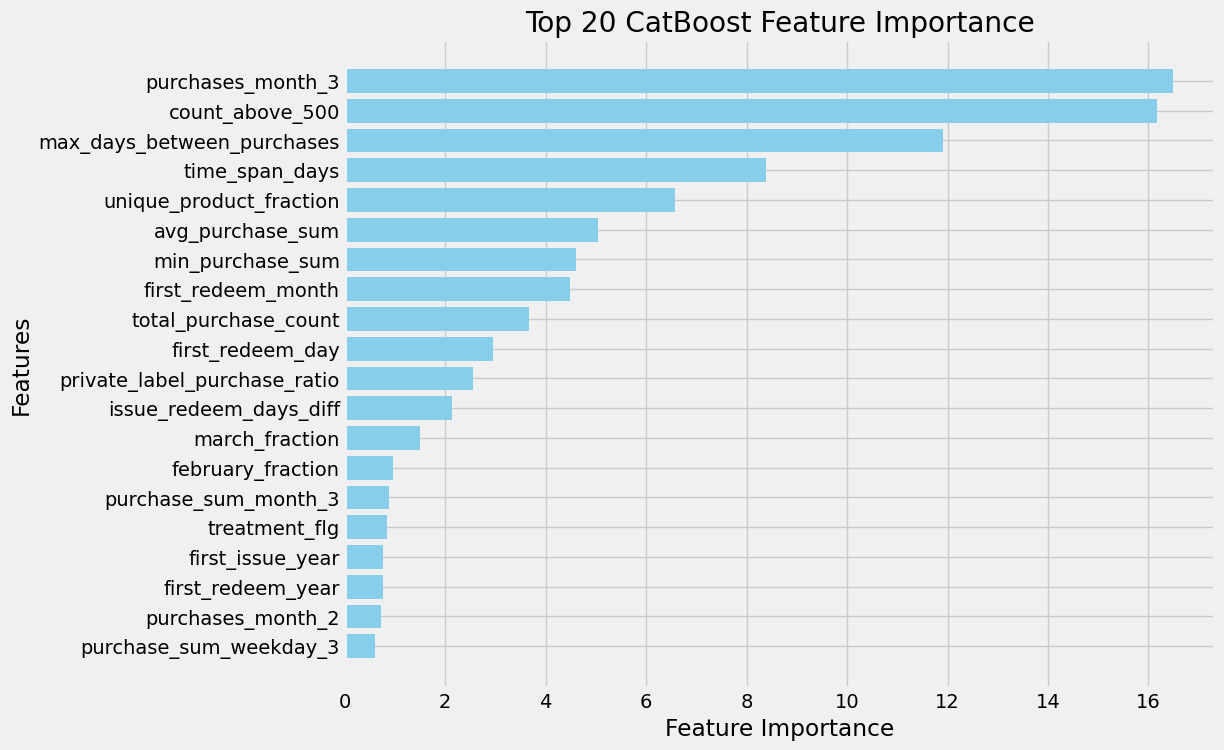

In [15]:
top_20_features = feature_importance_df.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 CatBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Model Quality

In [16]:
y_pred_tda = model_tda.predict(X_test_tda)

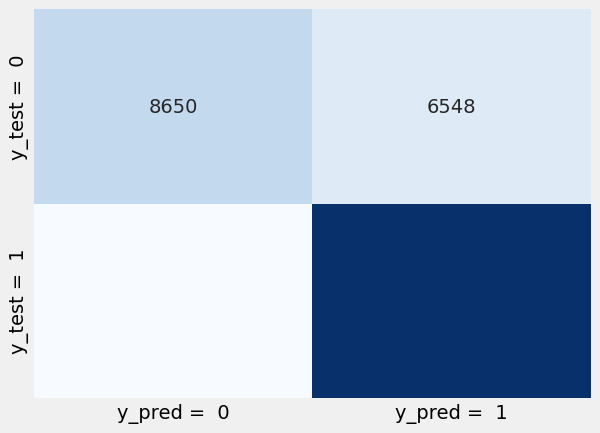

In [17]:
matrix_treatment = confusion_matrix(y_test_tda, y_pred_tda)
sns.heatmap(matrix_treatment, annot=True, fmt='g', cbar=None, cmap="Blues", 
            xticklabels=['y_pred =  0', 'y_pred =  1'], yticklabels=['y_test =  0', 'y_test =  1']);

## Quality metrics

In [18]:
accuracy_tda = accuracy_score(y_test_tda, y_pred_tda)
precision_tda = precision_score(y_test_tda, y_pred_tda)
recall_tda= recall_score(y_test_tda, y_pred_tda)
roc_auc_tda = roc_auc_score(y_test_tda, y_pred_tda)
f1_tda = f1_score(y_test_tda, y_pred_tda)
print(f'Accuracy: {accuracy_tda:.4f}')
print(f'Precision: {precision_tda:.4f}')
print(f'Recall: {recall_tda:.4f}')
print(f'ROC AUC: {roc_auc_tda:.4f}')
print(f'F1 Score: {f1_tda:.4f}')

Accuracy: 0.7227
Precision: 0.7558
Recall: 0.8168
ROC AUC: 0.6930
F1 Score: 0.7851


## Predictions

In [19]:
test

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000048b7a6,68.0,F,180,2018,12,15,2019,6,13,29724.00,...,0.250000,8,29724.00,6,28475.00,6,28475.00,4,24917.00,542.172285
000073194a,60.0,F,185,2017,5,23,2017,11,24,62719.92,...,0.176471,13,61370.92,12,60728.62,8,57335.49,7,55394.49,2126.855328
00007c7133,67.0,U,588,2017,5,22,2018,12,31,53998.72,...,0.727273,10,53658.72,10,53658.72,10,53658.72,9,52033.72,262.436585
00007f9014,45.0,F,542,2017,8,22,2019,2,15,39557.35,...,0.137931,18,37077.79,16,35812.13,14,34087.25,6,23599.51,110.490429
0000a90cf7,45.0,U,49,2017,5,20,2017,7,8,133328.28,...,0.514286,30,131647.80,25,128350.64,21,124926.53,12,112005.53,85.163683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffeacbe3e,47.0,F,86,2017,7,19,2017,10,13,47581.35,...,0.916667,9,46314.59,9,46314.59,8,45314.59,6,42754.81,120.542643
fffece623e,67.0,U,228,2018,5,13,2018,12,27,43103.46,...,0.500000,16,40978.89,13,39216.89,11,37469.89,7,32418.69,25.273913
ffff3dfff8,56.0,F,36,2018,11,1,2018,12,7,65810.71,...,0.470588,14,65354.56,12,64236.56,10,62558.36,7,58846.45,-38.400876


In [20]:
test_treatment = test.copy()
test_control = test.copy()

## Оцениваем модель, используя фичу treatment_flg - сначала 0, потом 1

In [21]:
test_treatment['treatment_flg'] = 1
test_control['treatment_flg'] = 0

## Достаем уверенность модели в присвоении определенного класса

In [22]:
test_treatment['pred_treatment'] = model_tda.predict_proba(test_treatment[features])[:, 1]
test_control['pred_control'] = model_tda.predict_proba(test_control[features])[:, 1]

In [23]:
test_tda = test.copy()

## Считаем аплифт

In [24]:
test_tda['pred_treatment'] = test_treatment['pred_treatment']
test_tda['pred_control'] = test_control['pred_control']
test_tda['uplift'] = test_tda['pred_treatment'] - test_tda['pred_control']

In [25]:
test_tda.sort_values(by='uplift', ascending=False)

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months,pred_treatment,pred_control,uplift
client_id,,,,,,,,,,,,,,,,,,,,,
b091194c8f,62.0,M,13,2019,3,9,2019,3,22,148.00,...,0,0.00,0,0.00,0,0.00,0.000000,0.590206,0.506070,0.084136
8f69df0aca,61.0,U,14,2019,3,10,2019,3,24,304.46,...,0,0.00,0,0.00,0,0.00,0.000000,0.553469,0.469829,0.083640
e96879ea1b,67.0,M,22,2019,3,8,2019,3,30,23.00,...,0,0.00,0,0.00,0,0.00,0.000000,0.551314,0.470642,0.080673
bacf846b06,56.0,U,19,2019,3,11,2019,3,30,26.40,...,0,0.00,0,0.00,0,0.00,0.000000,0.546921,0.466634,0.080287
5425efc387,64.0,F,31,2018,2,21,2018,3,24,103.96,...,0,0.00,0,0.00,0,0.00,0.000000,0.455253,0.375608,0.079645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c0a569d2cd,34.0,U,311,2017,6,27,2018,5,4,238727.25,...,58,222123.44,46,211935.69,24,182038.69,811.635875,0.974278,0.972476,0.001803
6b5da50177,84.0,U,123,2018,11,23,2019,3,26,62339.00,...,35,49180.00,21,37403.00,3,13942.00,293.461569,0.990226,0.988459,0.001768
4310e54b48,54.0,F,359,2017,5,25,2018,5,19,153110.00,...,56,118770.00,33,99138.00,10,67463.00,459.388458,0.983752,0.982017,0.001735


## Uplift VIZ

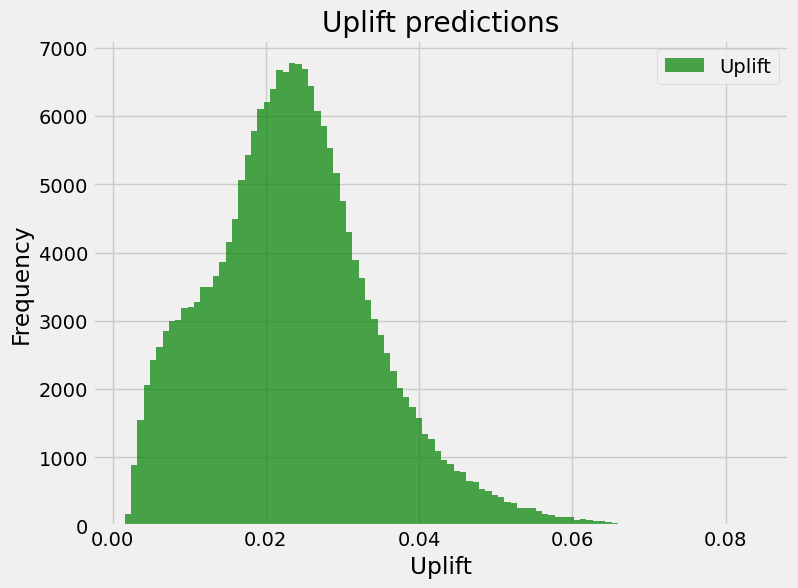

In [26]:
plt.figure(figsize=(8, 6))
plt.hist(test_tda['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift predictions')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

## True Viz

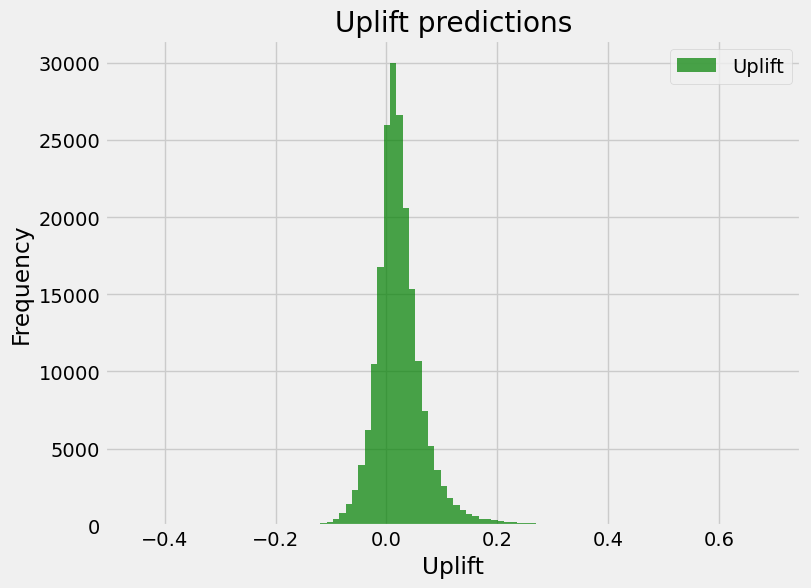

In [39]:
plt.figure(figsize=(8, 6))
plt.hist(uplift_sub['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift True')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

In [44]:
merged_df_tda = uplift_sub.merge(test_tda['uplift'], on='client_id', suffixes=('_true', '_pred'))

In [45]:
merged_df_tda

,uplift_true,uplift_pred
client_id,,
000048b7a6,-0.003131,0.026772
000073194a,0.021894,0.026923
00007c7133,0.082569,0.025929
00007f9014,0.025012,0.013845
0000a90cf7,0.052822,0.019987
...,...,...
fffeacbe3e,0.045508,0.030492
fffece623e,0.025312,0.021809
ffff3dfff8,0.044199,0.029549


## Model Quality

In [47]:
y_true_tda = merged_df_tda['uplift_true']
y_pred_tda = merged_df_tda['uplift_pred']

In [48]:
mae = mean_absolute_error(y_true_tda, y_pred_tda)
mse = mean_squared_error(y_true_tda, y_pred_tda)
rmse = np.sqrt(mse)

In [49]:
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

Mean Absolute Error (MAE): 0.030854
Mean Squared Error (MSE): 0.002323
Root Mean Squared Error (RMSE): 0.048196
R² Score: 0.116239


## Vizualize AUUC Uplift@K , UpliftMax

In [174]:
def plot_uplift_auuc(y_true, y_pred, k=0.2):
    """
    Построение AUUC с Uplift@K и Uplift_max

    Parameters:
    y_true: array-like, истинные значения uplift.
    y_pred: array-like, предсказания модели.
    k: float, пропорция выборки для подсчета Uplift@K.
    """
    # Сортировка данных по убыванию предсказанного uplift
    sorted_indices = np.argsort(-y_pred)
    y_true_sorted = y_true[sorted_indices]

    # Кумулятивный uplift
    cum_uplift = np.cumsum(y_true_sorted)

    # Нормализуем ось X (пропорция таргетированных наблюдений)
    x = np.arange(1, len(y_true) + 1) / len(y_true)

    # Uplift@K
    idx_k = int(len(y_true) * k)
    uplift_at_k = cum_uplift[idx_k]

    # Uplift_max
    uplift_max = np.max(cum_uplift)
    x_max = x[np.argmax(cum_uplift)] 

    # AUUC: площадь под кривой
    auuc = auc(x, cum_uplift)

    # Визуализация графика с Seaborn
    sns.set(style="whitegrid", palette="muted", font_scale=1.1)
    plt.figure(figsize=(10, 6))

    # Линия модели
    sns.lineplot(x=x, y=cum_uplift, label=f"Model AUUC = {auuc:.4f}", color='royalblue', linewidth=2)

    # Линия случайного таргетирования
    sns.lineplot(x=x, y=x * cum_uplift[-1], linestyle='--', color='gray', label="Random Targeting", linewidth=1.5)

    # Линия и точка для Uplift@K
    plt.axvline(k, linestyle='--', color='darkorange', label=f"Uplift@{int(k*100)}%", linewidth=2)
    plt.hlines(uplift_at_k, 0, k, colors='darkorange', linestyles='dotted', linewidth=2)

    # Точка для Uplift_max
    plt.scatter(x_max, uplift_max, color='red', s=60, label="Uplift_max", zorder=5)

    # Оформление графика
    plt.title("Cumulative Uplift Curve", fontsize=14, weight='bold')
    plt.xlabel("Proportion of population targeted", fontsize=12)
    plt.ylabel("Cumulative Uplift", fontsize=12)
    plt.legend(frameon=True, fontsize=10)
    plt.tight_layout()

    # Отображение графика
    plt.show()

    # Вывод значений метрик
    print(f"AUUC: {auuc:.4f}")
    print(f"Uplift@{int(k*100)}%: {uplift_at_k:.4f}")
    print(f"Uplift_max: {uplift_max:.4f}")

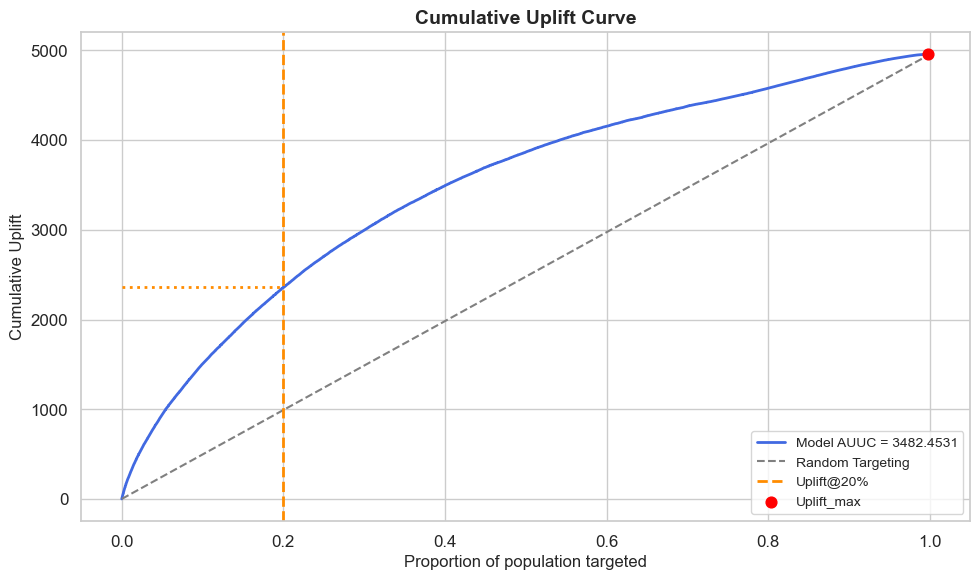

AUUC: 3482.4531
Uplift@20%: 2357.7588
Uplift_max: 4957.6586


In [175]:
y_true_tda = merged_df_tda['uplift_true'].values
y_pred_tda = merged_df_tda['uplift_pred'].values
plot_uplift_auuc(y_true_tda, y_pred_tda, k=0.2)

# 2) Two Models Aproach

## Подход с двумя моделями один из самых популярных и достаточно часто встречается в статьях, например [3] и [4]. Метод заключается в отдельном моделировании двух условных вероятностей на целевой и контрольной группах, а именно:

- **1)** Строится первая модель, оценивающая вероятность выполнения целевого действия среди клиентов, с которыми мы взаимодействовали.
- **2)** Строится вторая модель, оценивающая ту же вероятность, но среди клиентов, с которыми мы не производили коммуникацию.
- **3)** Затем для каждого клиента рассчитывается разность оценок вероятностей двух моделей

<img src="Two Models Aproach.png"  width="1000"/>

In [59]:
train_tma = train.copy()

In [60]:
train_tma

,treatment_flg,target,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,1,45.0,U,152,2017,8,5,2018,1,...,0.750000,4,40809.00,4,40809.00,4,40809.00,4,40809.00,-39.631391
000036f903,1,1,72.0,F,13,2017,4,10,2017,4,...,0.375000,26,57230.00,23,55149.00,21,53261.00,11,40187.00,418.904687
00010925a5,1,1,83.0,U,52,2018,7,24,2018,9,...,0.388889,13,26283.00,11,25182.00,9,23276.00,8,21761.00,95.305213
0001f552b0,1,1,33.0,F,424,2017,6,30,2018,8,...,0.466667,11,47085.83,11,47085.83,10,46257.99,8,43126.26,118.382838
00020e7b18,1,1,73.0,U,44,2017,11,27,2018,1,...,0.833333,17,558881.46,17,558881.46,16,558014.55,16,558014.55,145.234545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,0,0,35.0,F,76,2017,11,27,2018,2,...,0.111111,4,18720.23,4,18720.23,3,17913.92,3,17913.92,64.182615
fffe0ed719,0,1,69.0,U,88,2017,9,15,2017,12,...,0.733333,23,74902.47,19,72185.47,19,72185.47,15,67417.82,1878.334777
fffea1204c,0,1,73.0,F,40,2018,1,31,2018,3,...,0.000000,9,18061.91,7,16827.17,6,15887.37,5,14752.29,467.564253


## treatment_flg - не фича

In [61]:
non_features = ['target' , 'treatment_flg']
features_tma = [col for col in train_tma.columns if col not in non_features]

## Категориальные фичи

In [62]:
cat_features = [col for col in train_tma.columns if train_tma[col].dtype == 'object' and col not in non_features]

In [63]:
cat_features

['gender',
 'most_frequent_product',
 'most_frequent_brand',
 'most_frequent_store']

## Делю на две выборки под каждую модель

In [64]:
treatment_group = train_tma[train_tma['treatment_flg'] == 1]
control_group = train_tma[train_tma['treatment_flg'] == 0]

In [65]:
X_treatment = treatment_group[features_tma]
y_treatment = treatment_group['target']
X_control = control_group[features_tma]
y_control = control_group['target']

In [66]:
X_train_treatment, X_test_treatment, y_train_treatment, y_test_treatment = train_test_split(X_treatment, y_treatment, test_size=0.2, random_state=42)
X_train_control, X_test_control, y_train_control, y_test_control = train_test_split(X_control, y_control, test_size=0.2, random_state=42)

## Treatment Model

In [67]:
model_treatment = CatBoostClassifier(
    iterations = 2000,  
    learning_rate=0.01, 
    depth=3, 
    bootstrap_type='Bernoulli', 
    subsample=0.8,
    cat_features = cat_features,
    logging_level='Verbose',
    metric_period = 250,
    random_seed = 42,
    custom_loss = ['AUC']
)
model_treatment.fit(
    X_train_treatment, y_train_treatment,
    cat_features=cat_features,
    eval_set=(X_test_treatment, y_test_treatment),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5323421411
bestIteration = 1999



## Control Model

In [68]:
model_control = CatBoostClassifier(
    iterations = 2000,  
    learning_rate=0.005, 
    depth=3, 
    bootstrap_type='Bernoulli', 
    subsample=0.8,
    cat_features = cat_features,
    logging_level='Verbose',
    metric_period = 250,
    random_seed = 42,
    custom_loss = ['AUC']
)
model_control.fit(
    X_train_control, y_train_control,
    cat_features=cat_features,
    eval_set=(X_test_control, y_test_control),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.554386263
bestIteration = 1999



## Predictions

In [69]:
test

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000048b7a6,68.0,F,180,2018,12,15,2019,6,13,29724.00,...,0.250000,8,29724.00,6,28475.00,6,28475.00,4,24917.00,542.172285
000073194a,60.0,F,185,2017,5,23,2017,11,24,62719.92,...,0.176471,13,61370.92,12,60728.62,8,57335.49,7,55394.49,2126.855328
00007c7133,67.0,U,588,2017,5,22,2018,12,31,53998.72,...,0.727273,10,53658.72,10,53658.72,10,53658.72,9,52033.72,262.436585
00007f9014,45.0,F,542,2017,8,22,2019,2,15,39557.35,...,0.137931,18,37077.79,16,35812.13,14,34087.25,6,23599.51,110.490429
0000a90cf7,45.0,U,49,2017,5,20,2017,7,8,133328.28,...,0.514286,30,131647.80,25,128350.64,21,124926.53,12,112005.53,85.163683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffeacbe3e,47.0,F,86,2017,7,19,2017,10,13,47581.35,...,0.916667,9,46314.59,9,46314.59,8,45314.59,6,42754.81,120.542643
fffece623e,67.0,U,228,2018,5,13,2018,12,27,43103.46,...,0.500000,16,40978.89,13,39216.89,11,37469.89,7,32418.69,25.273913
ffff3dfff8,56.0,F,36,2018,11,1,2018,12,7,65810.71,...,0.470588,14,65354.56,12,64236.56,10,62558.36,7,58846.45,-38.400876


In [70]:
test_tma = test.copy()

## Calculate Uplift

In [71]:
test_tma['pred_treatment'] = model_treatment.predict_proba(test_tma)[:, 1]  # Вероятности для группы с воздействием
test_tma['pred_control'] = model_control.predict_proba(test_tma)[:, 1]  # Вероятности для группы без воздействия
test_tma['uplift'] = test_tma['pred_treatment'] - test_tma['pred_control']

In [72]:
test_tma.sort_values(by='uplift', ascending=False)

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months,pred_treatment,pred_control,uplift
client_id,,,,,,,,,,,,,,,,,,,,,
d874a01779,77.0,U,15,2019,3,9,2019,3,24,1227.25,...,1,1147.36,1,1147.36,0,0.00,0.000000,0.768750,0.291236,0.477514
507f44bde2,63.0,M,17,2019,3,6,2019,3,23,2087.76,...,1,1995.00,1,1995.00,0,0.00,0.000000,0.781602,0.308294,0.473308
9383ec9201,65.0,M,14,2019,3,8,2019,3,22,330.00,...,0,0.00,0,0.00,0,0.00,0.000000,0.821797,0.351386,0.470411
112741d4ae,65.0,U,11,2019,3,11,2019,3,22,2544.00,...,1,2544.00,1,2544.00,1,2544.00,0.000000,0.678320,0.213191,0.465129
5fe06228d8,50.0,U,16,2019,3,8,2019,3,24,624.00,...,0,0.00,0,0.00,0,0.00,0.000000,0.759658,0.301694,0.457964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3a9f76b22b,31.0,U,184,2019,1,29,2019,8,1,245229.21,...,13,244724.22,13,244724.22,11,242298.23,0.000000,0.284319,0.448051,-0.163732
2f49b309a8,5.0,U,180,2018,11,1,2019,4,30,116374.73,...,15,115181.40,15,115181.40,12,111595.40,2556.388678,0.290851,0.456285,-0.165434
99edaf3e34,45.0,M,180,2018,2,2,2018,8,1,90910.00,...,17,88802.00,15,87148.00,12,82784.00,0.000000,0.350567,0.519071,-0.168504


## Vizualization Uplift

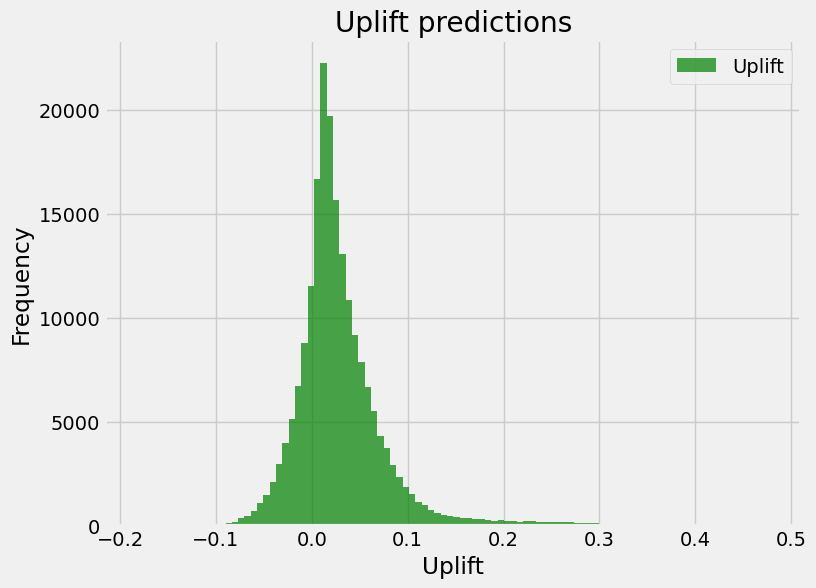

In [73]:
plt.figure(figsize=(8, 6))
plt.hist(test_tma['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift predictions')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

In [74]:
test_tma

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months,pred_treatment,pred_control,uplift
client_id,,,,,,,,,,,,,,,,,,,,,
000048b7a6,68.0,F,180,2018,12,15,2019,6,13,29724.00,...,6,28475.00,6,28475.00,4,24917.00,542.172285,0.424636,0.442554,-0.017918
000073194a,60.0,F,185,2017,5,23,2017,11,24,62719.92,...,12,60728.62,8,57335.49,7,55394.49,2126.855328,0.601483,0.571461,0.030022
00007c7133,67.0,U,588,2017,5,22,2018,12,31,53998.72,...,10,53658.72,10,53658.72,9,52033.72,262.436585,0.504662,0.455101,0.049561
00007f9014,45.0,F,542,2017,8,22,2019,2,15,39557.35,...,16,35812.13,14,34087.25,6,23599.51,110.490429,0.852522,0.851151,0.001372
0000a90cf7,45.0,U,49,2017,5,20,2017,7,8,133328.28,...,25,128350.64,21,124926.53,12,112005.53,85.163683,0.760268,0.757097,0.003171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffeacbe3e,47.0,F,86,2017,7,19,2017,10,13,47581.35,...,9,46314.59,8,45314.59,6,42754.81,120.542643,0.530225,0.463580,0.066645
fffece623e,67.0,U,228,2018,5,13,2018,12,27,43103.46,...,13,39216.89,11,37469.89,7,32418.69,25.273913,0.725244,0.713817,0.011428
ffff3dfff8,56.0,F,36,2018,11,1,2018,12,7,65810.71,...,12,64236.56,10,62558.36,7,58846.45,-38.400876,0.678821,0.627584,0.051237


## True viz

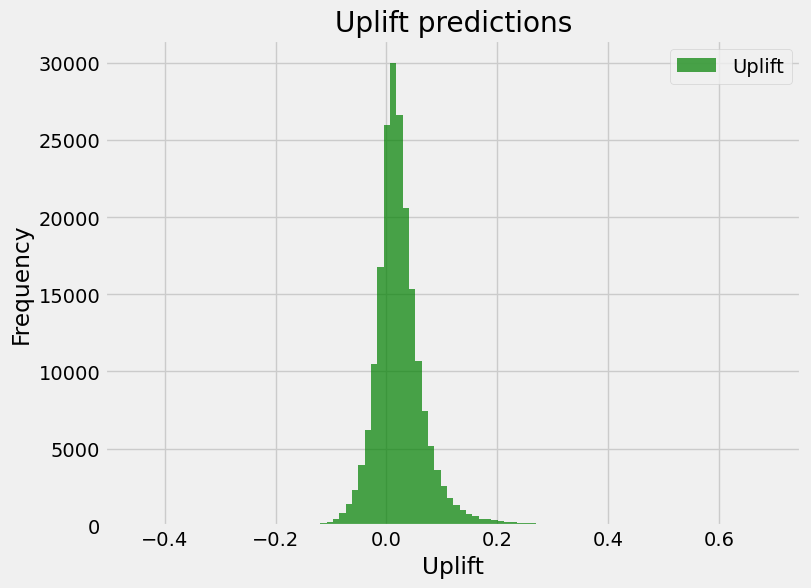

In [75]:
plt.figure(figsize=(8, 6))
plt.hist(uplift_sub['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift True')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

In [77]:
merged_df_tma = uplift_sub.merge(test_tma['uplift'], on='client_id', suffixes=('_true', '_pred'))

In [78]:
y_true_tma = merged_df_tma['uplift_true']
y_pred_tma = merged_df_tma['uplift_pred']

In [81]:
mae = mean_absolute_error(y_true_tma, y_pred_tma)
mse = mean_squared_error(y_true_tma, y_pred_tma)
rmse = np.sqrt(mse)

In [82]:
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

Mean Absolute Error (MAE): 0.036247
Mean Squared Error (MSE): 0.002978
Root Mean Squared Error (RMSE): 0.054568


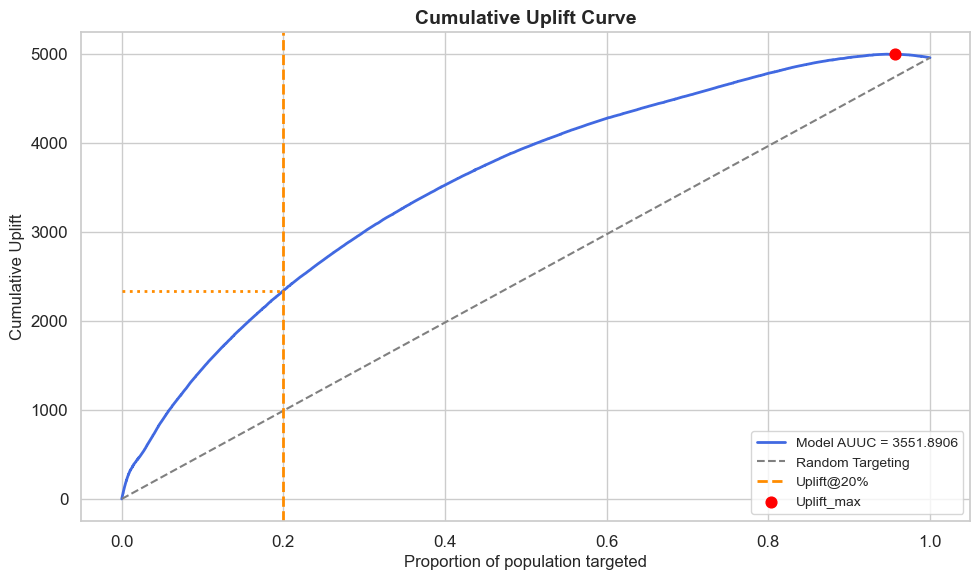

AUUC: 3551.8906
Uplift@20%: 2339.9669
Uplift_max: 4996.5126


In [193]:
y_true_tma = merged_df_tma['uplift_true'].values
y_pred_tma = merged_df_tma['uplift_pred'].values
plot_uplift_auuc(y_true_tma, y_pred_tma, k=0.2)

# 3) Class Transformation Approach (Regression)

In [84]:
train_cta = train.copy()

## Выборки равномерные => p (проспенсити скор) = 1/2, можно не обучать модель для оценки p

In [86]:
train_cta.groupby('treatment_flg')['target'].count()

treatment_flg
0    100058
1     99981
Name: target, dtype: int64

## Тогда просто сделаю вот так
$$ Z_i = Y_i \frac{W_i - p}{p(1-p)}
$$

In [87]:
train_cta['target_transformed'] = train_cta.apply(
    lambda row: 2 * row['target'] if row['treatment_flg'] == 1 else -2 * row['target'],
    axis=1
)

In [88]:
train_cta[['treatment_flg', 'target', 'target_transformed']].head(10)

,treatment_flg,target,target_transformed
client_id,,,
000012768d,0,1,-2
000036f903,1,1,2
00010925a5,1,1,2
0001f552b0,1,1,2
00020e7b18,1,1,2
000220a0a7,0,1,-2
00022fd34f,1,1,2
0002ce2217,0,1,-2
00031cbbe6,0,1,-2


In [89]:
train_cta

,treatment_flg,target,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,...,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months,target_transformed
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,1,45.0,U,152,2017,8,5,2018,1,...,4,40809.00,4,40809.00,4,40809.00,4,40809.00,-39.631391,-2
000036f903,1,1,72.0,F,13,2017,4,10,2017,4,...,26,57230.00,23,55149.00,21,53261.00,11,40187.00,418.904687,2
00010925a5,1,1,83.0,U,52,2018,7,24,2018,9,...,13,26283.00,11,25182.00,9,23276.00,8,21761.00,95.305213,2
0001f552b0,1,1,33.0,F,424,2017,6,30,2018,8,...,11,47085.83,11,47085.83,10,46257.99,8,43126.26,118.382838,2
00020e7b18,1,1,73.0,U,44,2017,11,27,2018,1,...,17,558881.46,17,558881.46,16,558014.55,16,558014.55,145.234545,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,0,0,35.0,F,76,2017,11,27,2018,2,...,4,18720.23,4,18720.23,3,17913.92,3,17913.92,64.182615,0
fffe0ed719,0,1,69.0,U,88,2017,9,15,2017,12,...,23,74902.47,19,72185.47,19,72185.47,15,67417.82,1878.334777,-2
fffea1204c,0,1,73.0,F,40,2018,1,31,2018,3,...,9,18061.91,7,16827.17,6,15887.37,5,14752.29,467.564253,-2


## Новый target_transformed

In [90]:
non_features_cta = ['treatment_flg', 'target', 'target_transformed']
features_cta = [col for col in train_cta.columns if col not in non_features_cta]

## Категориальные фичи

In [91]:
cat_features_cta = [col for col in train_cta.columns if train_cta[col].dtype == 'object' and col not in non_features_cta]

## X, y

In [92]:
X_cta = train_cta[features_cta]
y_cta = train_cta['target_transformed']

In [93]:
X_train_cta, X_test_cta, y_train_cta, y_test_cta = train_test_split(X_cta, y_cta, test_size=0.2, random_state=42)

In [94]:
model_cta = CatBoostRegressor(
    iterations=2000,  
    learning_rate=0.005, 
    depth=3, 
    bootstrap_type='Bernoulli', 
    subsample=0.8,
    cat_features=cat_features,
    logging_level='Verbose',
    metric_period=250,
    random_seed=42,  
    eval_metric='RMSE' 
)

model_cta.fit(
    X_train_cta, y_train_cta,
    cat_features=cat_features,
    eval_set=(X_test_cta, y_test_cta),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1.569230215
bestIteration = 1999



In [95]:
feature_importances = model_cta.get_feature_importance()
feature_names = X_train_cta.columns 
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

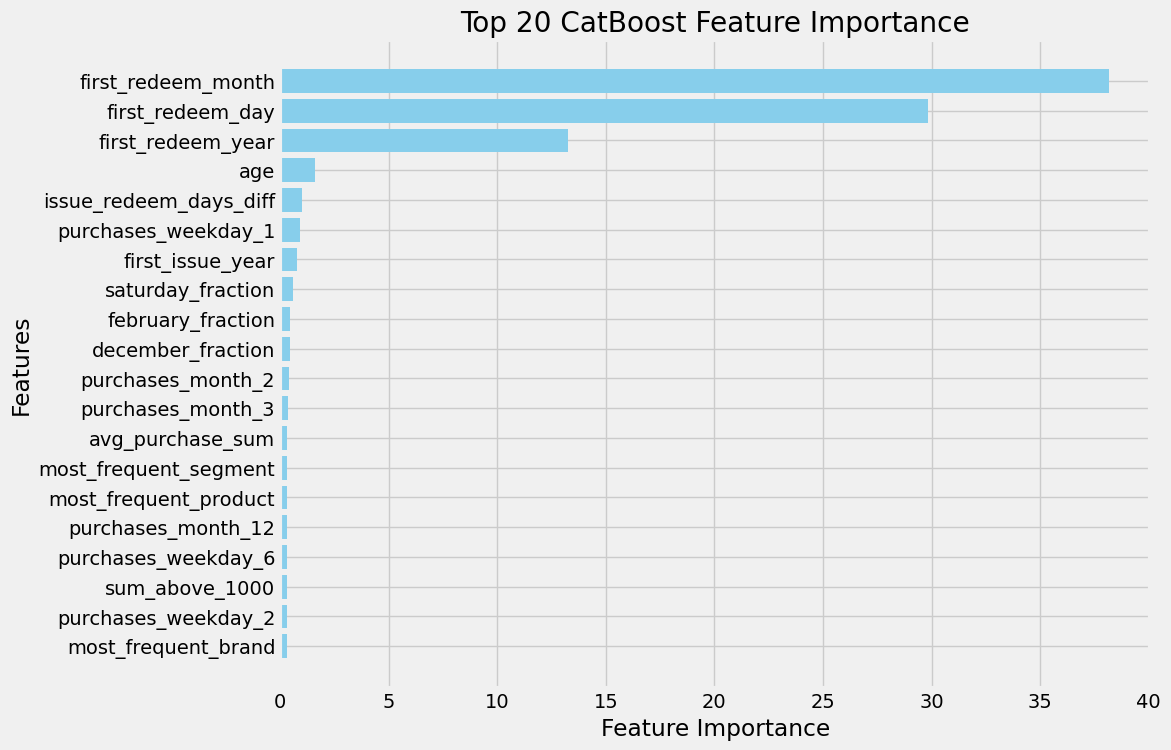

In [96]:
top_20_features = feature_importance_df.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 CatBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [97]:
test_cta = test.copy()

In [98]:
test_cta['uplift'] = model_cta.predict(test_cta[features_cta])

In [99]:
test_cta.sort_values(by='uplift', ascending=False)

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months,uplift
client_id,,,,,,,,,,,,,,,,,,,,,
b091194c8f,62.0,M,13,2019,3,9,2019,3,22,148.00,...,0,0.00,0,0.00,0,0.00,0,0.00,0.000000,0.576202
7d3d59525f,76.0,U,63,2019,1,19,2019,3,23,606.00,...,0,0.00,0,0.00,0,0.00,0,0.00,0.000000,0.575088
cfc2ce6e37,77.0,U,22,2019,3,1,2019,3,23,1817.00,...,1,1535.00,1,1535.00,1,1535.00,0,0.00,0.000000,0.567640
6e09f458c0,71.0,U,46,2019,2,4,2019,3,22,1483.00,...,1,555.00,0,0.00,0,0.00,0,0.00,0.000000,0.563744
0b93f192ee,69.0,M,19,2019,3,3,2019,3,22,446.00,...,0,0.00,0,0.00,0,0.00,0,0.00,0.000000,0.562164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d07edbc6ca,30.0,F,28,2017,4,10,2017,5,8,1788851.00,...,109,1788551.00,105,1786094.00,103,1784172.00,97,1775417.00,615.415787,-0.277914
52a6a2714f,37.0,F,5,2017,5,29,2017,6,3,1447670.30,...,96,1446052.31,94,1444766.57,90,1441226.79,85,1434424.33,247.480348,-0.287138
6f9215a0b1,39.0,F,35,2017,5,31,2017,7,5,4050936.34,...,84,4050936.34,84,4050936.34,84,4050936.34,83,4049640.34,266.313929,-0.311876


## Predicts viz

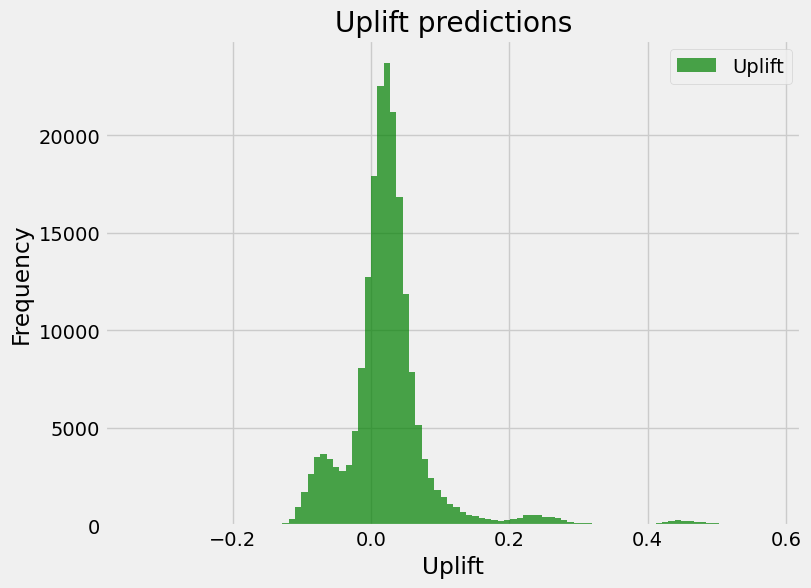

In [100]:
plt.figure(figsize=(8, 6))
plt.hist(test_cta['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift predictions')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

## True Viz

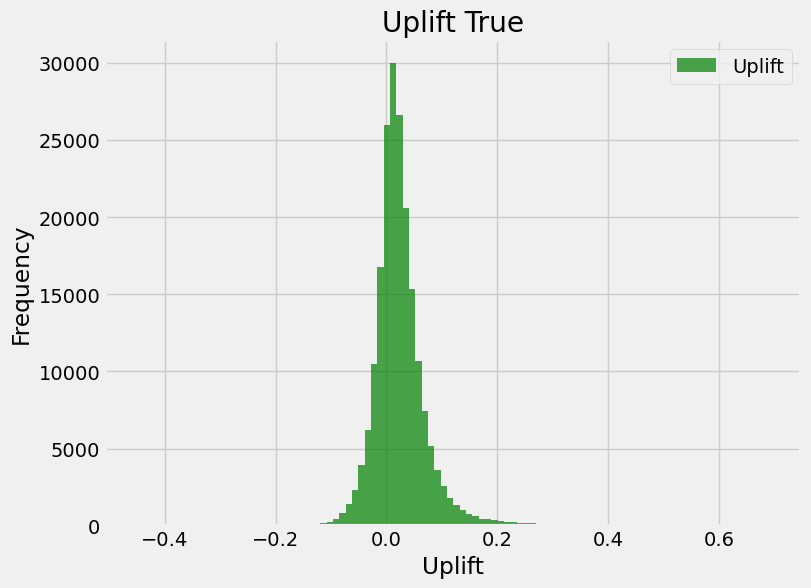

In [102]:
plt.figure(figsize=(8, 6))
plt.hist(uplift_sub['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift True')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

In [103]:
merged_df_cta = uplift_sub.merge(test_cta['uplift'], on='client_id', suffixes=('_true', '_pred'))

In [104]:
y_true_cta = merged_df_cta['uplift_true']
y_pred_cta = merged_df_cta['uplift_pred']

In [105]:
mae = mean_absolute_error(y_true_cta, y_pred_cta)
mse = mean_squared_error(y_true_cta, y_pred_cta)
rmse = np.sqrt(mse)

In [106]:
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

Mean Absolute Error (MAE): 0.045600
Mean Squared Error (MSE): 0.005647
Root Mean Squared Error (RMSE): 0.075148


## AUUC

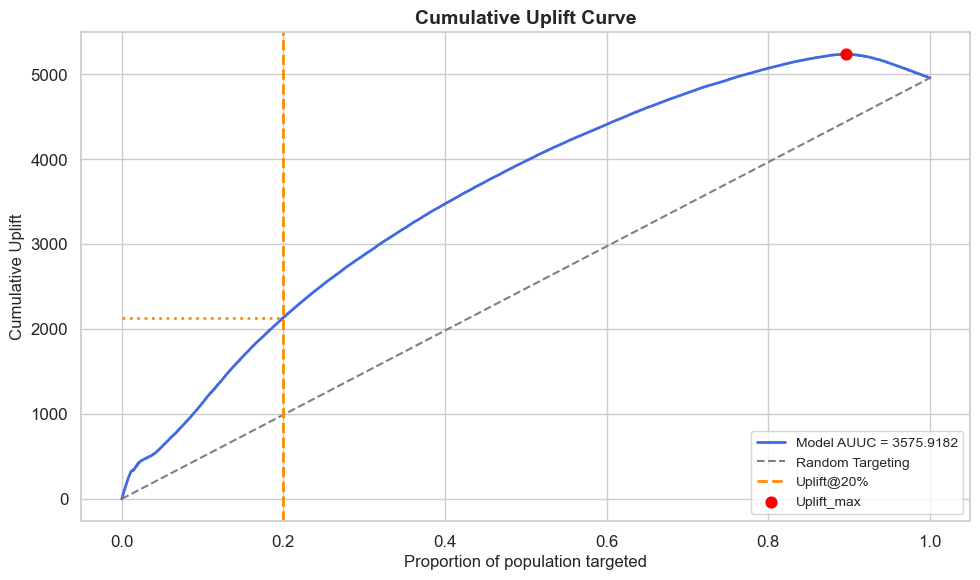

AUUC: 3575.9182
Uplift@20%: 2134.8435
Uplift_max: 5235.6980


In [194]:
y_true_cta = merged_df_cta['uplift_true'].values
y_pred_cta = merged_df_cta['uplift_pred'].values
plot_uplift_auuc(y_true_cta, y_pred_cta, k=0.2)

# 4) Modeling Uplift Directly

In [108]:
train_mud = train.copy()

In [109]:
train_mud

,treatment_flg,target,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,1,45.0,U,152,2017,8,5,2018,1,...,0.750000,4,40809.00,4,40809.00,4,40809.00,4,40809.00,-39.631391
000036f903,1,1,72.0,F,13,2017,4,10,2017,4,...,0.375000,26,57230.00,23,55149.00,21,53261.00,11,40187.00,418.904687
00010925a5,1,1,83.0,U,52,2018,7,24,2018,9,...,0.388889,13,26283.00,11,25182.00,9,23276.00,8,21761.00,95.305213
0001f552b0,1,1,33.0,F,424,2017,6,30,2018,8,...,0.466667,11,47085.83,11,47085.83,10,46257.99,8,43126.26,118.382838
00020e7b18,1,1,73.0,U,44,2017,11,27,2018,1,...,0.833333,17,558881.46,17,558881.46,16,558014.55,16,558014.55,145.234545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,0,0,35.0,F,76,2017,11,27,2018,2,...,0.111111,4,18720.23,4,18720.23,3,17913.92,3,17913.92,64.182615
fffe0ed719,0,1,69.0,U,88,2017,9,15,2017,12,...,0.733333,23,74902.47,19,72185.47,19,72185.47,15,67417.82,1878.334777
fffea1204c,0,1,73.0,F,40,2018,1,31,2018,3,...,0.000000,9,18061.91,7,16827.17,6,15887.37,5,14752.29,467.564253


## В либе нужно указывать тритмент стрингой

In [120]:
train_mud['treatment_flg'] = train_mud['treatment_flg'].astype(str)

## Label Encoder

In [121]:
le = LabelEncoder()
for col in ['gender', 'most_frequent_product', 'most_frequent_brand', 'most_frequent_store']:
    train_mud[col] = le.fit_transform(train_mud[col])

In [122]:
X = train_mud.drop(columns=['target', 'treatment_flg'])
y = train_mud['target']
treatment = train_mud['treatment_flg']

In [123]:
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)

## Data Scaler

In [124]:
scaler = StandardScaler()

In [125]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Uplift Model (Random Forest)

In [151]:
uplift_model = UpliftRandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    min_samples_leaf=20,
    min_samples_treatment=50,
    n_reg=100,
    control_name='0'
)

In [152]:
uplift_model.fit(X_train_scaled, treatment_train.values, y_train.values)

In [153]:
uplift_preds = uplift_model.predict(X_test_scaled)

In [154]:
uplift_preds

array([[0.02223176],
       [0.03424045],
       [0.04114084],
       ...,
       [0.03625376],
       [0.02183132],
       [0.03062202]])

In [155]:
test_mud = test.copy()

In [156]:
test_mud

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000048b7a6,68.0,F,180,2018,12,15,2019,6,13,29724.00,...,0.250000,8,29724.00,6,28475.00,6,28475.00,4,24917.00,542.172285
000073194a,60.0,F,185,2017,5,23,2017,11,24,62719.92,...,0.176471,13,61370.92,12,60728.62,8,57335.49,7,55394.49,2126.855328
00007c7133,67.0,U,588,2017,5,22,2018,12,31,53998.72,...,0.727273,10,53658.72,10,53658.72,10,53658.72,9,52033.72,262.436585
00007f9014,45.0,F,542,2017,8,22,2019,2,15,39557.35,...,0.137931,18,37077.79,16,35812.13,14,34087.25,6,23599.51,110.490429
0000a90cf7,45.0,U,49,2017,5,20,2017,7,8,133328.28,...,0.514286,30,131647.80,25,128350.64,21,124926.53,12,112005.53,85.163683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffeacbe3e,47.0,F,86,2017,7,19,2017,10,13,47581.35,...,0.916667,9,46314.59,9,46314.59,8,45314.59,6,42754.81,120.542643
fffece623e,67.0,U,228,2018,5,13,2018,12,27,43103.46,...,0.500000,16,40978.89,13,39216.89,11,37469.89,7,32418.69,25.273913
ffff3dfff8,56.0,F,36,2018,11,1,2018,12,7,65810.71,...,0.470588,14,65354.56,12,64236.56,10,62558.36,7,58846.45,-38.400876


In [157]:
le = LabelEncoder()
for col in ['gender', 'most_frequent_product', 'most_frequent_brand', 'most_frequent_store']:
    test_mud[col] = le.fit_transform(test_mud[col])

In [158]:
test_mud

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,private_label_purchase_ratio,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months
client_id,,,,,,,,,,,,,,,,,,,,,
000048b7a6,68.0,0,180,2018,12,15,2019,6,13,29724.00,...,0.250000,8,29724.00,6,28475.00,6,28475.00,4,24917.00,542.172285
000073194a,60.0,0,185,2017,5,23,2017,11,24,62719.92,...,0.176471,13,61370.92,12,60728.62,8,57335.49,7,55394.49,2126.855328
00007c7133,67.0,2,588,2017,5,22,2018,12,31,53998.72,...,0.727273,10,53658.72,10,53658.72,10,53658.72,9,52033.72,262.436585
00007f9014,45.0,0,542,2017,8,22,2019,2,15,39557.35,...,0.137931,18,37077.79,16,35812.13,14,34087.25,6,23599.51,110.490429
0000a90cf7,45.0,2,49,2017,5,20,2017,7,8,133328.28,...,0.514286,30,131647.80,25,128350.64,21,124926.53,12,112005.53,85.163683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffeacbe3e,47.0,0,86,2017,7,19,2017,10,13,47581.35,...,0.916667,9,46314.59,9,46314.59,8,45314.59,6,42754.81,120.542643
fffece623e,67.0,2,228,2018,5,13,2018,12,27,43103.46,...,0.500000,16,40978.89,13,39216.89,11,37469.89,7,32418.69,25.273913
ffff3dfff8,56.0,0,36,2018,11,1,2018,12,7,65810.71,...,0.470588,14,65354.56,12,64236.56,10,62558.36,7,58846.45,-38.400876


In [159]:
X_scaled = scaler.transform(test_mud)
X_scaled

array([[ 1.36066330e+00, -1.20669961e+00, -2.44376702e-03, ...,
        -4.71135058e-01, -3.52600610e-01, -4.54056731e-02],
       [ 8.57653599e-01, -1.20669961e+00,  3.10091927e-02, ...,
        -7.60526255e-02, -1.60368392e-01,  5.38969554e-02],
       [ 1.29778708e+00,  9.96424603e-01,  2.72731775e+00, ...,
         1.87335663e-01, -1.81565947e-01, -6.29350399e-02],
       ...,
       [ 6.06148750e-01, -1.20669961e+00, -9.65889007e-01, ...,
        -7.60526255e-02, -1.38595669e-01, -8.17867281e-02],
       [-1.46876625e+00, -1.20669961e+00, -5.04238163e-01, ...,
        -4.71135058e-01, -2.67596445e-01, -7.93803744e-02],
       [ 9.83406023e-01,  9.96424603e-01, -2.44376702e-03, ...,
        -2.07746770e-01,  1.25032856e+00, -7.93803744e-02]])

In [160]:
test_mud['uplift'] =  uplift_model.predict(X_scaled)

In [161]:
test_mud

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months,uplift
client_id,,,,,,,,,,,,,,,,,,,,,
000048b7a6,68.0,0,180,2018,12,15,2019,6,13,29724.00,...,8,29724.00,6,28475.00,6,28475.00,4,24917.00,542.172285,0.026418
000073194a,60.0,0,185,2017,5,23,2017,11,24,62719.92,...,13,61370.92,12,60728.62,8,57335.49,7,55394.49,2126.855328,0.024938
00007c7133,67.0,2,588,2017,5,22,2018,12,31,53998.72,...,10,53658.72,10,53658.72,10,53658.72,9,52033.72,262.436585,0.025844
00007f9014,45.0,0,542,2017,8,22,2019,2,15,39557.35,...,18,37077.79,16,35812.13,14,34087.25,6,23599.51,110.490429,0.029045
0000a90cf7,45.0,2,49,2017,5,20,2017,7,8,133328.28,...,30,131647.80,25,128350.64,21,124926.53,12,112005.53,85.163683,0.019467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffeacbe3e,47.0,0,86,2017,7,19,2017,10,13,47581.35,...,9,46314.59,9,46314.59,8,45314.59,6,42754.81,120.542643,0.027585
fffece623e,67.0,2,228,2018,5,13,2018,12,27,43103.46,...,16,40978.89,13,39216.89,11,37469.89,7,32418.69,25.273913,0.025552
ffff3dfff8,56.0,0,36,2018,11,1,2018,12,7,65810.71,...,14,65354.56,12,64236.56,10,62558.36,7,58846.45,-38.400876,0.026166


## Predicted Viz

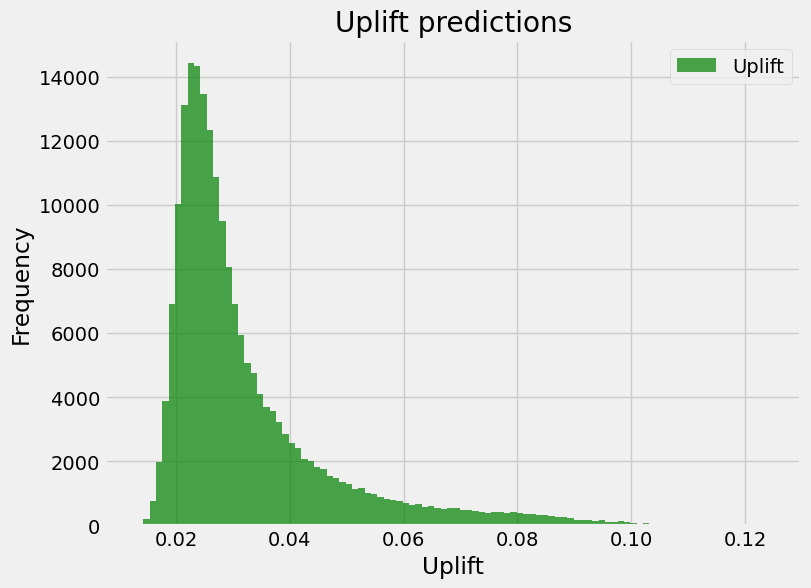

In [162]:
plt.figure(figsize=(8, 6))
plt.hist(test_mud['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift predictions')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

## True Viz

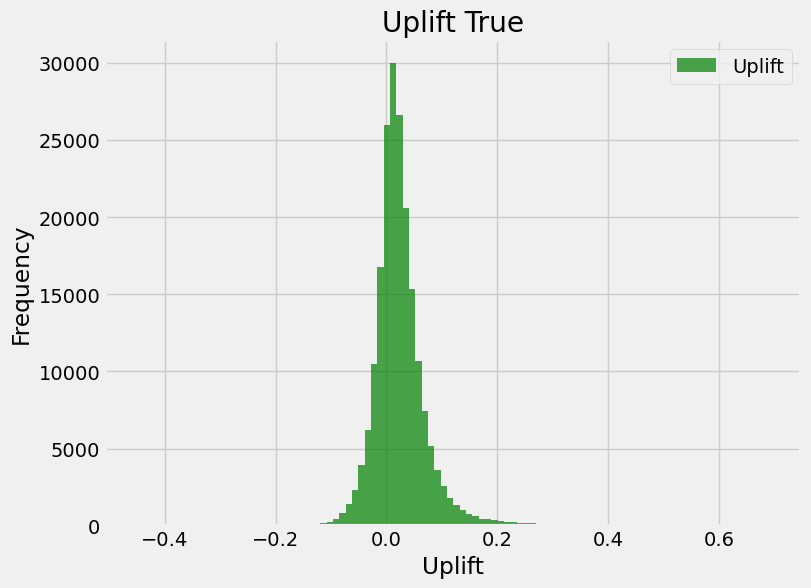

In [163]:
plt.figure(figsize=(8, 6))
plt.hist(uplift_sub['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift True')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

In [164]:
merged_df_mud = uplift_sub.merge(test_mud['uplift'], on='client_id', suffixes=('_true', '_pred'))

In [165]:
merged_df_mud

,uplift_true,uplift_pred
client_id,,
000048b7a6,-0.003131,0.026418
000073194a,0.021894,0.024938
00007c7133,0.082569,0.025844
00007f9014,0.025012,0.029045
0000a90cf7,0.052822,0.019467
...,...,...
fffeacbe3e,0.045508,0.027585
fffece623e,0.025312,0.025552
ffff3dfff8,0.044199,0.026166


In [166]:
y_true_mud = merged_df_mud['uplift_true']
y_pred_mud = merged_df_mud['uplift_pred']

In [167]:
mae = mean_absolute_error(y_true_mud, y_pred_mud)
mse = mean_squared_error(y_true_mud, y_pred_mud)
rmse = np.sqrt(mse)

In [168]:
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

Mean Absolute Error (MAE): 0.033699
Mean Squared Error (MSE): 0.002437
Root Mean Squared Error (RMSE): 0.049369


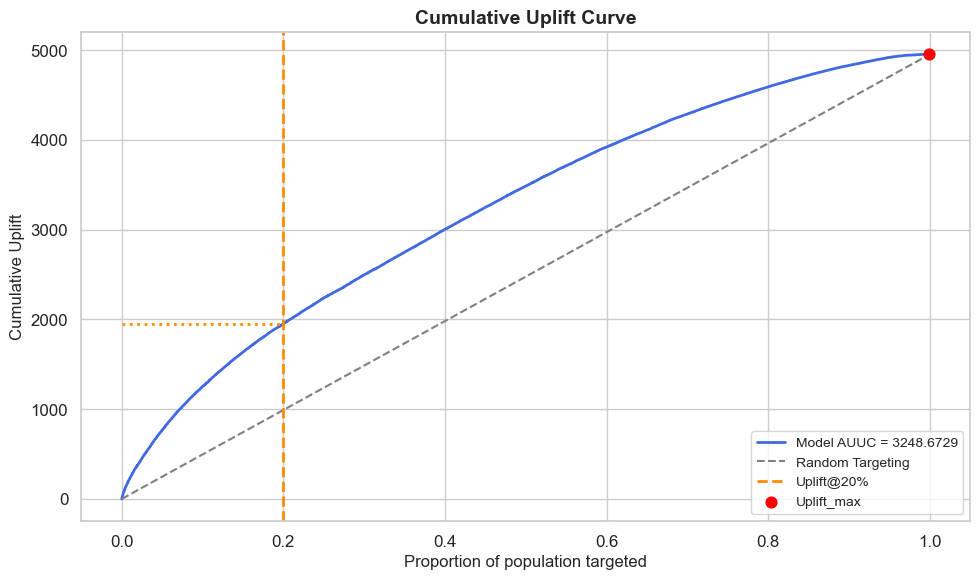

AUUC: 3248.6729
Uplift@20%: 1952.2035
Uplift_max: 4957.1974


In [195]:
y_true_mud = merged_df_mud['uplift_true'].values
y_pred_mud = merged_df_mud['uplift_pred'].values
plot_uplift_auuc(y_true_mud, y_pred_mud, k=0.2)

# 5) Class Transformation Approach (Classification)

In [176]:
train_ctac = train.copy()

## Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году на ICML, который заключается в прогнозировании немного измененной целевой переменной
$$
Z_i = Y_i \cdot W_i + (1 - Y_i) \cdot (1 - W_i)
$$

In [177]:
train_ctac['z'] = train_ctac['target'] * train_ctac['treatment_flg'] + (1 - train_ctac['target']) * (1 - train_ctac['treatment_flg'])

In [178]:
train_ctac

,treatment_flg,target,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,...,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months,z
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,1,45.0,U,152,2017,8,5,2018,1,...,4,40809.00,4,40809.00,4,40809.00,4,40809.00,-39.631391,0
000036f903,1,1,72.0,F,13,2017,4,10,2017,4,...,26,57230.00,23,55149.00,21,53261.00,11,40187.00,418.904687,1
00010925a5,1,1,83.0,U,52,2018,7,24,2018,9,...,13,26283.00,11,25182.00,9,23276.00,8,21761.00,95.305213,1
0001f552b0,1,1,33.0,F,424,2017,6,30,2018,8,...,11,47085.83,11,47085.83,10,46257.99,8,43126.26,118.382838,1
00020e7b18,1,1,73.0,U,44,2017,11,27,2018,1,...,17,558881.46,17,558881.46,16,558014.55,16,558014.55,145.234545,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,0,0,35.0,F,76,2017,11,27,2018,2,...,4,18720.23,4,18720.23,3,17913.92,3,17913.92,64.182615,1
fffe0ed719,0,1,69.0,U,88,2017,9,15,2017,12,...,23,74902.47,19,72185.47,19,72185.47,15,67417.82,1878.334777,0
fffea1204c,0,1,73.0,F,40,2018,1,31,2018,3,...,9,18061.91,7,16827.17,6,15887.37,5,14752.29,467.564253,0


## Features

In [180]:
non_features_ctac = ['treatment_flg', 'target', 'z']
features_ctac = [col for col in train_ctac.columns if col not in non_features_ctac]

In [181]:
cat_features_ctac = [col for col in train_ctac.columns if train_ctac[col].dtype == 'object' and col not in non_features_ctac]

In [182]:
cat_features_ctac

['gender',
 'most_frequent_product',
 'most_frequent_brand',
 'most_frequent_store']

## X, y

In [183]:
X_ctac = train_ctac[features_ctac]
y_ctac = train_ctac['z']

## Train Test

In [187]:
X_train_ctac, X_test_ctac, y_train_ctac, y_test_ctac = train_test_split(X_ctac, y_ctac, test_size=0.2, random_state=42)

In [198]:
model_ctac = CatBoostClassifier(
    iterations = 5000,  
    learning_rate=0.001, 
    depth=3, 
    bootstrap_type='Bernoulli', 
    subsample=0.8,
    cat_features = cat_features_ctac,
    logging_level='Verbose',
    metric_period = 250,
    random_seed = 42,
    custom_loss = ['AUC']
)
model_ctac.fit(
    X_train_ctac, y_train_ctac,
    cat_features=cat_features_ctac,
    eval_set=(X_test_ctac, y_test_ctac),
    verbose=False,
    plot=True,
    early_stopping_rounds=100
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6910346471
bestIteration = 4999



## Feature Importances

In [204]:
feature_importances = model_ctac.get_feature_importance()
feature_names = X_train_ctac.columns 
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

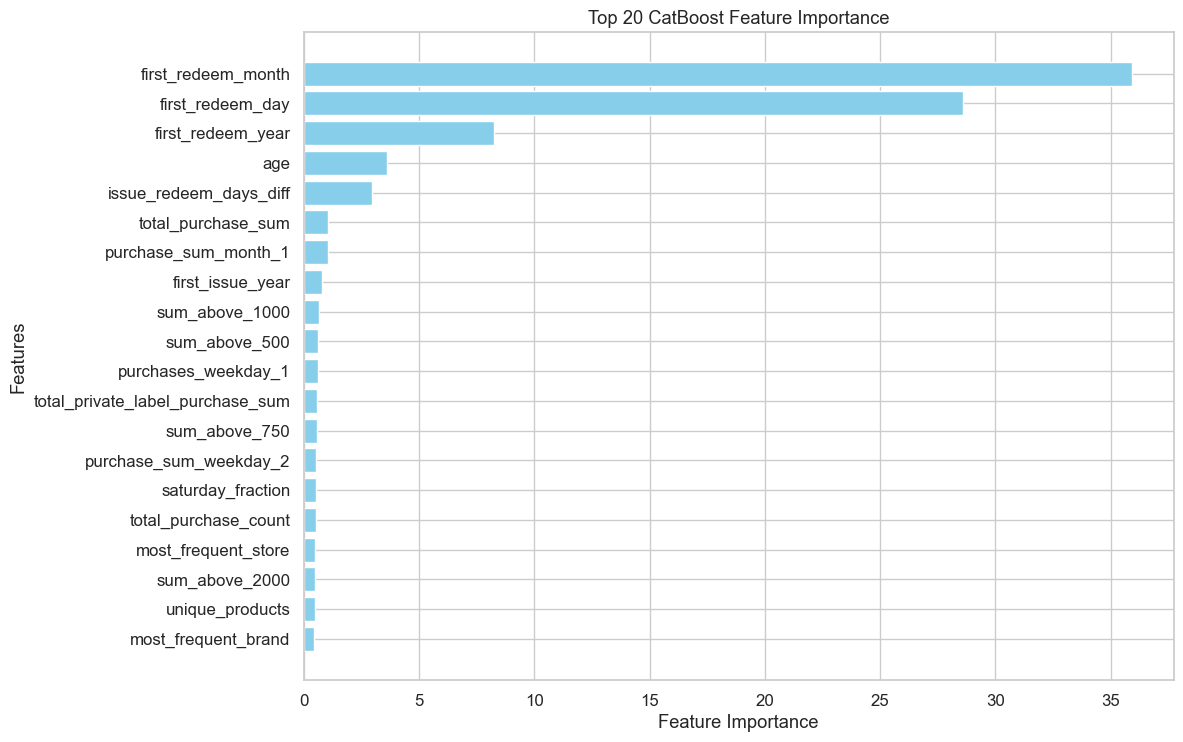

In [205]:
top_20_features = feature_importance_df.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 CatBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [206]:
test_ctac = test.copy()

## Считаю аплифт
$$
\textit{uplift} = 2 \cdot P(Z = 1) - 1
$$

In [209]:
test_ctac['uplift'] = 2 * model_ctac.predict_proba(test_ctac)[:, 1] - 1
test_ctac['uplift']

client_id
000048b7a6    0.006704
000073194a    0.032201
00007c7133    0.028672
00007f9014    0.026026
0000a90cf7    0.007573
                ...   
fffeacbe3e    0.026063
fffece623e    0.022457
ffff3dfff8    0.025698
ffffaab9da    0.009028
ffffeb5619    0.022477
Name: uplift, Length: 200123, dtype: float64

In [211]:
test_ctac.sort_values(by='uplift', ascending=False)

,age,gender,issue_redeem_days_diff,first_issue_year,first_issue_month,first_issue_day,first_redeem_year,first_redeem_month,first_redeem_day,total_purchase_sum,...,count_above_500,sum_above_500,count_above_750,sum_above_750,count_above_1000,sum_above_1000,count_above_2000,sum_above_2000,growth_rate_last_3_months,uplift
client_id,,,,,,,,,,,,,,,,,,,,,
082cb60128,68.0,M,40,2019,2,11,2019,3,23,225.00,...,0,0.00,0,0.00,0,0.00,0,0.00,0.000000,0.261326
7d3d59525f,76.0,U,63,2019,1,19,2019,3,23,606.00,...,0,0.00,0,0.00,0,0.00,0,0.00,0.000000,0.258107
11641ccb68,60.0,U,49,2019,2,2,2019,3,23,1241.00,...,1,567.00,0,0.00,0,0.00,0,0.00,0.000000,0.255521
b091194c8f,62.0,M,13,2019,3,9,2019,3,22,148.00,...,0,0.00,0,0.00,0,0.00,0,0.00,0.000000,0.253502
99de1f552c,69.0,M,46,2019,2,5,2019,3,23,419.00,...,0,0.00,0,0.00,0,0.00,0,0.00,0.000000,0.252435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c18940c264,30.0,F,180,2019,1,7,2019,7,6,367448.91,...,28,366528.97,28,366528.97,25,364005.66,22,359253.11,0.000000,-0.037094
2dcb28e1ea,27.0,U,256,2018,10,4,2019,6,17,1644868.56,...,7,1644834.56,7,1644834.56,7,1644834.56,7,1644834.56,-23.563555,-0.038169
4a98b7d7ca,15.0,F,246,2017,5,31,2018,2,1,2064172.23,...,141,2061119.12,136,2058128.80,132,2054647.20,111,2022483.25,374.499454,-0.044252


## Predictions Viz

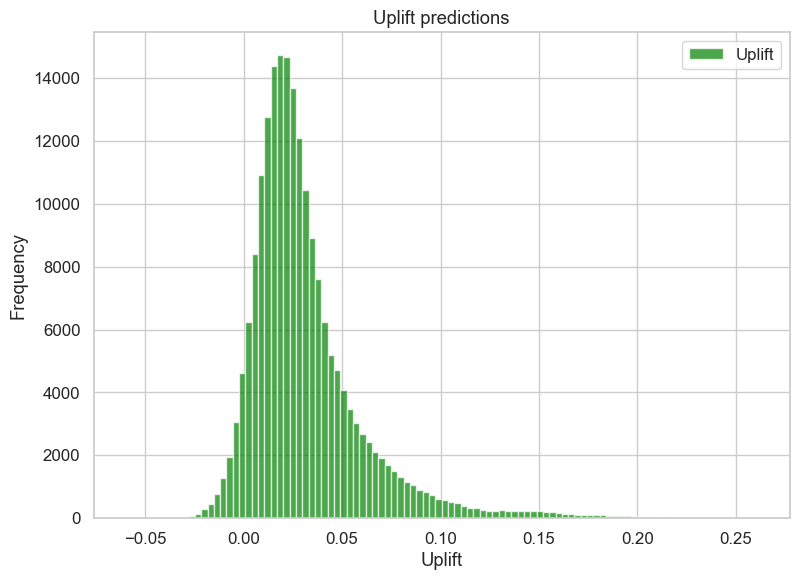

In [213]:
plt.figure(figsize=(8, 6))
plt.hist(test_ctac['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift predictions')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

## True Viz

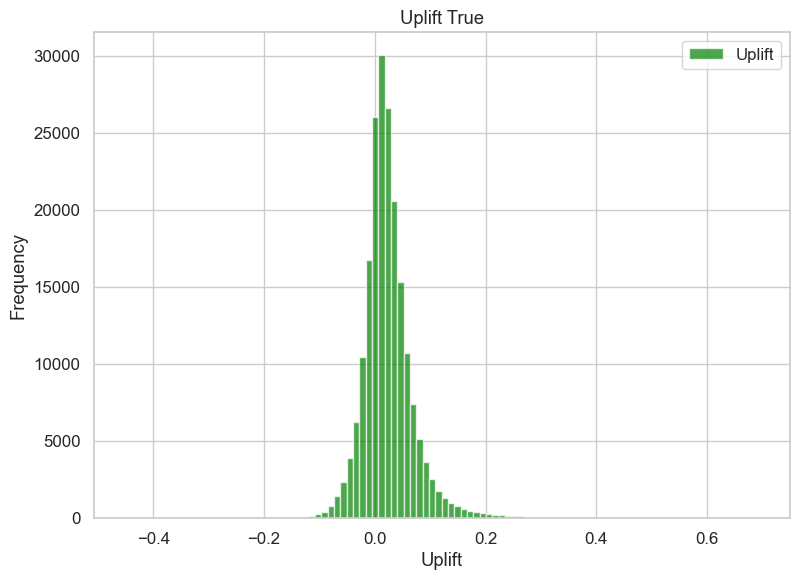

In [214]:
plt.figure(figsize=(8, 6))
plt.hist(uplift_sub['uplift'], bins=100, color='green', alpha=0.7, label='Uplift')  
plt.title('Uplift True')  
plt.xlabel('Uplift')  
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

In [215]:
merged_df_ctac = uplift_sub.merge(test_ctac['uplift'], on='client_id', suffixes=('_true', '_pred'))

In [216]:
y_true_ctac = merged_df_ctac['uplift_true']
y_pred_ctac = merged_df_ctac['uplift_pred']

In [217]:
mae = mean_absolute_error(y_true_ctac, y_pred_ctac)
mse = mean_squared_error(y_true_ctac, y_pred_ctac)
rmse = np.sqrt(mse)

In [218]:
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

Mean Absolute Error (MAE): 0.032323
Mean Squared Error (MSE): 0.002304
Root Mean Squared Error (RMSE): 0.048005


## AUUC

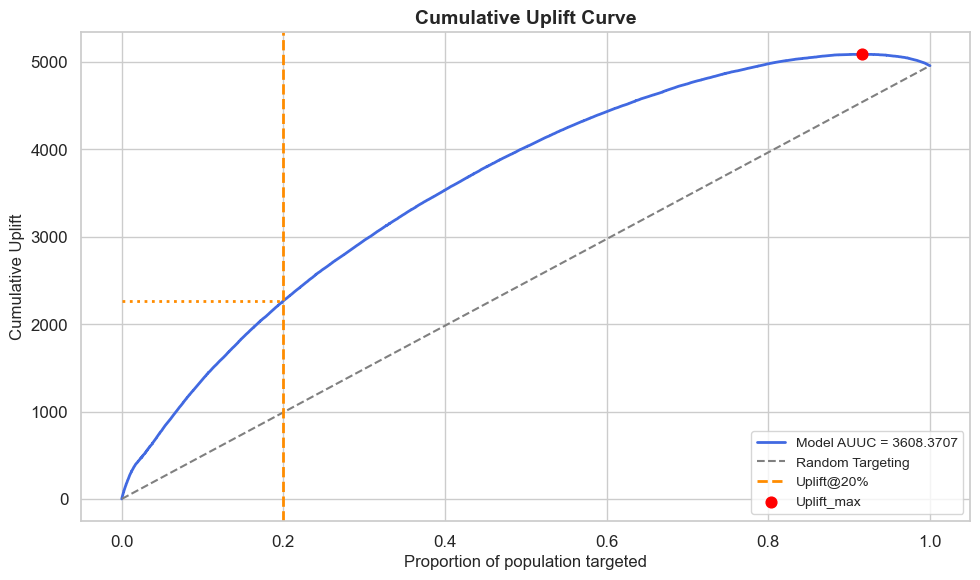

AUUC: 3608.3707
Uplift@20%: 2266.9259
Uplift_max: 5088.3080


In [219]:
y_true_ctac = merged_df_ctac['uplift_true'].values
y_pred_ctac = merged_df_ctac['uplift_pred'].values
plot_uplift_auuc(y_true_ctac, y_pred_ctac, k=0.2)